In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}


<IPython.core.display.Javascript object>

In [2]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import sqlite3
from scipy.optimize import curve_fit

%matplotlib inline 



# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr1 = [(0.00, 0.00, 0.00),
      (1.00, 0.82, 0.67),
      (0.31, 0.24, 0.00),
      (0.45, 0.70, 0.90),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (1.00, 0.00, 0.00)]

Clr = ['#004A98',
       '#C5C5C5',
       '#FF538C',
       '#4DC6FF',
       '#FFA42C',
       '#C050FF',
       '#75FF84',
       '#C70000'
       ]



# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 30}


plt.rc('font', **font)
# plt.rc('text', usetex=True)

# Reard BARD csv

In [3]:
BARD = pd.read_csv('data/BARD/AR_catalog.csv')
BARD['Abs Flux'] = np.abs(BARD['P Flux']) + np.abs(BARD['N Flux'])
BARD['Tot Area'] = np.abs(BARD['P Area']) + np.abs(BARD['N Area'])
BARD

,MDI day,Year,Month,Day,Hour,Minute,Second,BMR Label,P Flux,P Area,...,N Flux,N Area,N Latitude,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,Abs Flux,Tot Area
0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1224,1996.0,5.0,9.0,1.0,4.0,5.042,0,1.160000e+22,3.710000e+19,...,-4.160000e+21,1.500000e+19,-7.50162,-104.20700,1.670980,3.89860,-26.81730,1.0,1.576000e+22,5.210000e+19
3,1225,1996.0,5.0,10.0,1.0,4.0,5.074,0,1.290000e+22,4.450000e+19,...,-1.030000e+22,4.480000e+19,-6.58779,-113.36500,4.585970,11.66560,-3.62339,1.0,2.320000e+22,8.930000e+19
4,1226,1996.0,5.0,11.0,5.0,51.0,5.111,0,1.290000e+22,4.240000e+19,...,-1.000000e+22,3.970000e+19,-6.58545,-112.72600,4.568500,10.76620,-2.49239,1.0,2.290000e+22,8.210000e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12941,6674,2011.0,4.0,11.0,1.0,39.0,1.205,3827,1.320000e+21,6.780000e+18,...,-5.230000e+21,2.900000e+19,19.87190,65.33300,2.765550,9.40131,-7.67273,-1.0,6.550000e+21,3.578000e+19
12942,6674,2011.0,4.0,11.0,1.0,39.0,1.205,3830,9.030000e+21,2.790000e+19,...,-7.880000e+21,2.980000e+19,20.56230,14.66400,2.190970,7.70101,27.54320,-1.0,1.691000e+22,5.770000e+19
12943,6674,2011.0,4.0,11.0,1.0,39.0,1.205,3831,1.790000e+21,6.770000e+18,...,-1.890000e+21,7.450000e+18,-20.84490,-9.23839,0.987701,2.97380,-32.94500,1.0,3.680000e+21,1.422000e+19
12944,6674,2011.0,4.0,11.0,1.0,39.0,1.205,3833,1.070000e+22,5.530000e+19,...,-6.870000e+21,3.560000e+19,12.53100,-16.03240,3.452280,9.95017,9.50171,-1.0,1.757000e+22,9.090000e+19


In [4]:
# Procesing objects

# Assembling pandas dataframe with columns
Feature = BARD.groupby(['BMR Label']).sum()*np.nan
Feature['Life'] = np.nan
Feature


,MDI day,Year,Month,Day,Hour,Minute,Second,P Flux,P Area,P Latitude,...,N Area,N Latitude,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,Abs Flux,Tot Area,Life
BMR Label,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
Feature.index

Index([   0,    2,    3,    4,    6,    7,    8,    9,   10,   11,
       ...
       3822, 3823, 3824, 3825, 3827, 3828, 3829, 3830, 3831, 3833],
      dtype='int64', name='BMR Label', length=2456)

In [6]:
for i in Feature.index:
# for i in np.arange(0,5):
    snglFtr = BARD.loc[BARD['BMR Label'] == i,:].copy().reset_index(drop=True)

    if any((snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values))):
        maxSzin = (snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values)).nonzero()[0][0]
        
        Feature.loc[i,:] = snglFtr.loc[maxSzin, :]
        Feature.loc[i,'Life'] = np.nanmax(snglFtr['MDI day'])-np.nanmin(snglFtr['MDI day'])+1
    

Feature

,MDI day,Year,Month,Day,Hour,Minute,Second,P Flux,P Area,P Latitude,...,N Area,N Latitude,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,Abs Flux,Tot Area,Life
BMR Label,,,,,,,,,,,,,,,,,,,,,
0,1225.0,1996.0,5.0,10.0,1.0,4.0,5.074,1.290000e+22,4.450000e+19,-5.85562,...,4.480000e+19,-6.58779,-113.36500,4.58597,11.66560,-3.623390,1.0,2.320000e+22,8.930000e+19,1233.0
2,1273.0,1996.0,6.0,27.0,3.0,16.0,5.513,2.380000e+21,1.320000e+19,10.69190,...,8.010000e+18,13.52780,-2.56786,1.17082,6.11243,-27.687400,-1.0,4.410000e+21,2.121000e+19,4.0
3,1276.0,1996.0,6.0,30.0,1.0,40.0,5.458,2.150000e+21,8.910000e+18,21.85520,...,1.330000e+19,25.34570,-69.90560,1.47881,6.49129,32.584900,1.0,4.140000e+21,2.221000e+19,4.0
4,1286.0,1996.0,7.0,10.0,1.0,40.0,5.259,2.570000e+21,1.200000e+19,-12.11700,...,8.740000e+18,-8.53072,-124.20900,1.40070,6.67482,32.557400,1.0,4.050000e+21,2.074000e+19,7.0
6,1286.0,1996.0,7.0,10.0,1.0,40.0,5.259,1.680000e+22,3.290000e+19,-10.94770,...,2.330000e+19,-10.63910,-115.37400,1.87056,6.14343,2.885150,1.0,2.676000e+22,5.620000e+19,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,6669.0,2011.0,4.0,6.0,1.0,35.0,1.229,3.590000e+21,1.130000e+19,22.83700,...,1.540000e+19,22.81120,34.97580,1.64717,2.75620,0.535785,-1.0,7.630000e+21,2.670000e+19,4.0
3829,6674.0,2011.0,4.0,11.0,1.0,39.0,1.205,7.050000e+21,2.610000e+19,18.23650,...,1.720000e+19,15.93000,28.25310,1.40188,4.62332,29.953500,-1.0,1.351000e+22,4.330000e+19,4.0
3830,6674.0,2011.0,4.0,11.0,1.0,39.0,1.205,9.030000e+21,2.790000e+19,24.11490,...,2.980000e+19,20.56230,14.66400,2.19097,7.70101,27.543200,-1.0,1.691000e+22,5.770000e+19,4.0


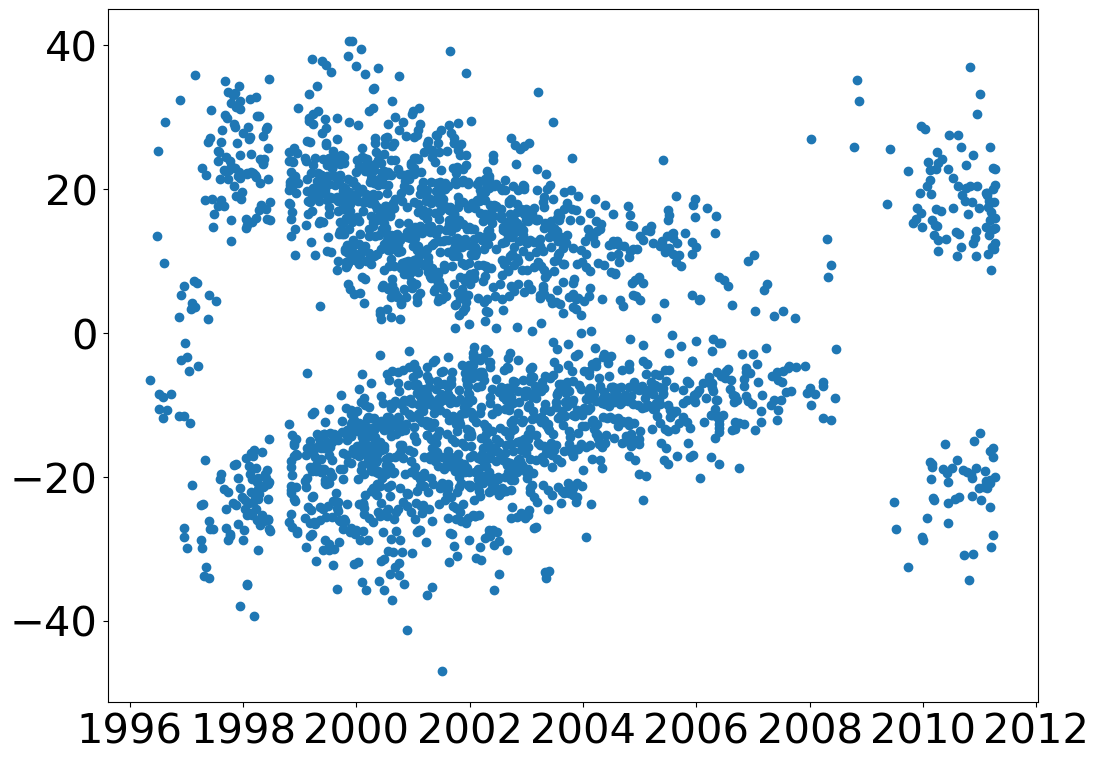

In [7]:
Feature['date'] = pd.to_datetime(dict(year=Feature.Year, month=Feature.Month, day=Feature.Day))

fig = plt.figure(figsize=(12,9))
plt.scatter(Feature['date'], Feature['N Latitude'])

In [8]:
Feature.to_pickle('data/BARD/bard_MDI.pnds')

In [9]:
BARD = pd.read_csv('data/BARD/AR_catalog_21-22-tt.csv')
BARD['Abs Flux'] = np.abs(BARD['P Flux']) + np.abs(BARD['N Flux'])
BARD['Tot Area'] = np.abs(BARD['P Area']) + np.abs(BARD['N Area'])
BARD

,MDI day,Year,Month,Day,Hour,Minute,Second,BMR Label,P Flux,P Area,...,N Latitude,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,DM,QM,Abs Flux,Tot Area
0,2203,1976,1,13,17,26,59,1,6.690000e+21,1.590000e+19,...,-10.0093,-78.61010,2.917570,5.55380,0.458870,1,0,0,2.129000e+22,6.730000e+19
1,2204,1976,1,14,16,54,18,1,5.120000e+21,1.420000e+19,...,-11.7538,-80.06720,2.923800,6.59613,-3.127040,1,0,0,1.602000e+22,6.250000e+19
2,2205,1976,1,15,17,4,59,1,4.330000e+21,1.330000e+19,...,-11.6683,-79.30930,2.224070,6.30269,-7.323860,1,0,0,1.074000e+22,4.580000e+19
3,2206,1976,1,16,16,20,59,1,5.900000e+21,1.680000e+19,...,-11.9814,-79.88130,2.297400,5.90564,-6.838050,1,0,0,1.263000e+22,4.890000e+19
4,2207,1976,1,17,17,3,23,1,6.390000e+21,2.130000e+19,...,-11.9959,-79.89250,2.215580,5.11839,-10.227600,1,0,0,1.212000e+22,5.080000e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19728,8499,1993,4,9,18,29,14,8153,2.230000e+22,6.530000e+19,...,-10.9459,73.93760,3.058490,6.80852,-0.895149,1,0,0,4.180000e+22,1.313000e+20
19729,8499,1993,4,9,18,29,14,8151,2.840000e+22,1.110000e+20,...,-10.2874,101.20700,1.539750,6.31214,-40.780300,1,0,0,3.234000e+22,1.268000e+20
19730,8499,1993,4,9,18,29,14,8156,3.170000e+21,1.190000e+19,...,3.1189,77.26160,1.437130,3.90613,10.653600,-1,0,0,7.690000e+21,2.970000e+19
19731,8499,1993,4,9,18,29,14,8158,1.150000e+22,6.840000e+19,...,14.6984,9.02829,4.173570,10.93040,21.844400,-1,0,0,2.042000e+22,1.310000e+20


In [10]:
Feature = BARD.groupby(['BMR Label']).sum()*np.nan
Feature['Life'] = np.nan
Feature

,MDI day,Year,Month,Day,Hour,Minute,Second,P Flux,P Area,P Latitude,...,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,DM,QM,Abs Flux,Tot Area,Life
BMR Label,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
for i in Feature.index:
# for i in np.arange(0,5):
    snglFtr = BARD.loc[BARD['BMR Label'] == i,:].copy().reset_index(drop=True)

    if any((snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values))):
        maxSzin = (snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values)).nonzero()[0][0]
        
        Feature.loc[i,:] = snglFtr.loc[maxSzin, :]
        Feature.loc[i,'Life'] = np.nanmax(snglFtr['MDI day'])-np.nanmin(snglFtr['MDI day'])+1
    

Feature

,MDI day,Year,Month,Day,Hour,Minute,Second,P Flux,P Area,P Latitude,...,N Longitude,N Avg. Radius,Plrt Dis.,Tilt,Ldng Plrt,DM,QM,Abs Flux,Tot Area,Life
BMR Label,,,,,,,,,,,,,,,,,,,,,
1,2203.0,1976.0,1.0,13.0,17.0,26.0,59.0,6.690000e+21,1.590000e+19,-9.90945,...,-78.61010,2.917570,5.55380,0.458870,1.0,0.0,0.0,2.129000e+22,6.730000e+19,5.0
3,2236.0,1976.0,2.0,15.0,18.0,19.0,8.0,2.370000e+21,1.170000e+19,-11.10810,...,-71.38100,1.098730,3.53839,-17.839600,1.0,0.0,0.0,3.760000e+21,1.944000e+19,3.0
4,2241.0,1976.0,2.0,20.0,18.0,43.0,18.0,2.490000e+21,1.440000e+19,-2.69185,...,168.78900,1.427780,4.11957,-17.508200,1.0,0.0,0.0,4.880000e+21,2.810000e+19,6.0
8,2263.0,1976.0,3.0,13.0,21.0,24.0,36.0,3.080000e+21,1.270000e+19,-33.71000,...,-67.43920,1.331930,4.03489,-26.862800,-1.0,0.0,0.0,5.880000e+21,2.790000e+19,5.0
13,2415.0,1976.0,8.0,12.0,21.0,14.0,0.0,1.790000e+21,9.400000e+18,23.78620,...,71.76340,0.964019,4.28208,22.086000,1.0,0.0,0.0,3.130000e+21,1.656000e+19,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,8498.0,1993.0,4.0,8.0,19.0,0.0,36.0,2.580000e+21,1.070000e+19,-6.12504,...,69.14660,0.697130,5.99918,-28.000600,1.0,0.0,0.0,3.174000e+21,1.491000e+19,6.0
8153,8499.0,1993.0,4.0,9.0,18.0,29.0,14.0,2.230000e+22,6.530000e+19,-9.92835,...,73.93760,3.058490,6.80852,-0.895149,1.0,0.0,0.0,4.180000e+22,1.313000e+20,7.0
8156,8499.0,1993.0,4.0,9.0,18.0,29.0,14.0,3.170000e+21,1.190000e+19,3.84049,...,77.26160,1.437130,3.90613,10.653600,-1.0,0.0,0.0,7.690000e+21,2.970000e+19,2.0


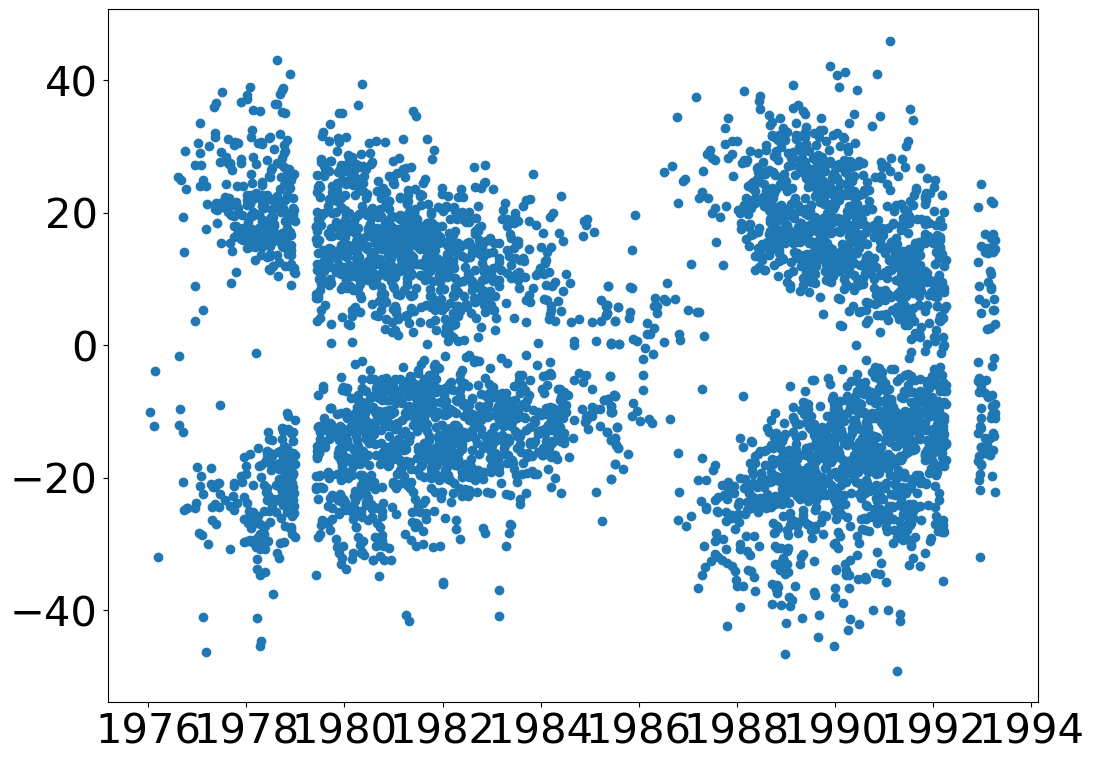

In [12]:
Feature['date'] = pd.to_datetime(dict(year=Feature.Year, month=Feature.Month, day=Feature.Day))

fig = plt.figure(figsize=(12,9))
plt.scatter(Feature['date'], Feature['N Latitude'])

In [13]:
Feature.to_pickle('data/BARD/bard_KPVT.pnds')

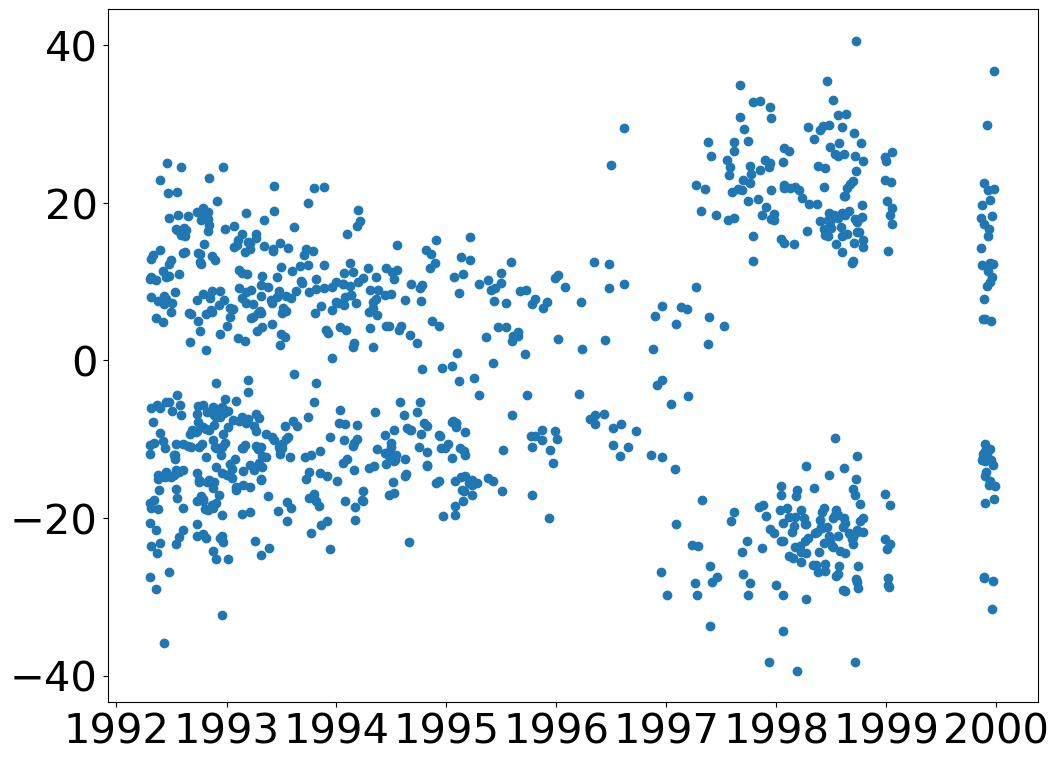

In [14]:
BARD = pd.read_csv('data/BARD/AR_catalog_22_23-tt.csv')
BARD['Abs Flux'] = np.abs(BARD['P Flux']) + np.abs(BARD['N Flux'])
BARD['Tot Area'] = np.abs(BARD['P Area']) + np.abs(BARD['N Area'])

Feature = BARD.groupby(['BMR Label']).sum()*np.nan
Feature['Life'] = np.nan

for i in Feature.index:
# for i in np.arange(0,5):
    snglFtr = BARD.loc[BARD['BMR Label'] == i,:].copy().reset_index(drop=True)

    if any((snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values))):
        maxSzin = (snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values)).nonzero()[0][0]
        
        Feature.loc[i,:] = snglFtr.loc[maxSzin, :]
        Feature.loc[i,'Life'] = np.nanmax(snglFtr['MDI day'])-np.nanmin(snglFtr['MDI day'])+1
    

Feature['date'] = pd.to_datetime(dict(year=Feature.Year, month=Feature.Month, day=Feature.Day))

fig = plt.figure(figsize=(12,9))
plt.scatter(Feature['date'], Feature['N Latitude'])

In [15]:
Feature.to_pickle('data/BARD/bard_SPMG.pnds')

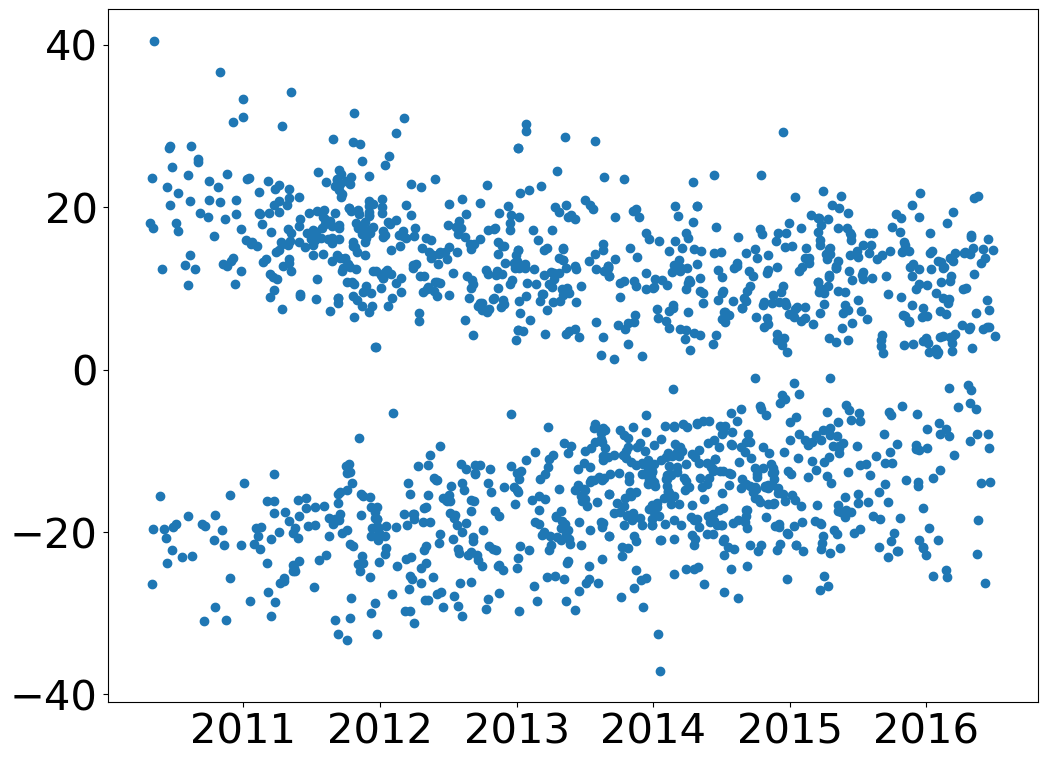

In [16]:
BARD = pd.read_csv('data/BARD/AR_catalog_24-tt.csv')
BARD['Abs Flux'] = np.abs(BARD['P Flux']) + np.abs(BARD['N Flux'])
BARD['Tot Area'] = np.abs(BARD['P Area']) + np.abs(BARD['N Area'])

Feature = BARD.groupby(['BMR Label']).sum()*np.nan
Feature['Life'] = np.nan

for i in Feature.index:
# for i in np.arange(0,5):
    snglFtr = BARD.loc[BARD['BMR Label'] == i,:].copy().reset_index(drop=True)

    if any((snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values))):
        maxSzin = (snglFtr['Abs Flux'].values == np.nanmax(snglFtr['Abs Flux'].values)).nonzero()[0][0]
        
        Feature.loc[i,:] = snglFtr.loc[maxSzin, :]
        Feature.loc[i,'Life'] = np.nanmax(snglFtr['MDI day'])-np.nanmin(snglFtr['MDI day'])+1
    

Feature['date'] = pd.to_datetime(dict(year=Feature.Year, month=Feature.Month, day=Feature.Day))

fig = plt.figure(figsize=(12,9))
plt.scatter(Feature['date'], Feature['N Latitude'])

In [17]:
Feature.to_pickle('data/BARD/bard_HMI.pnds')